# Combined Regression Analysis

Group together ECT and MST data, use changes in spectral features (no colinearities) to predict clinical outcome


HAMD_ratio ~ treatment_type(discrete) + n_sessions(discrete) + d_exponent  + d_theta_osc_perc  
HAMD_diff ~ treatment_type(discrete) + n_sessions(discreet) + d_exponent + d_theta_osc_perc

For ECT - one figure showing one patient with EMERGENCE of delta/theta oscillations

plot correlations with residuals, not just raw data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
import statsmodels.api as sm
from pingouin import ttest, corr

from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'
#from plotting_functions import plot_feature_prepost

In [2]:
ECT_path = '../saved_files_appeal/ect_files/ect_clin_eeg_diff.csv'
MST_path = '../saved_files_appeal/mst_files/mst_clin_eeg_diff.csv'

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
def plot_feature_prepost(exp_df_mean, feature='', tx_type=''):
    """Creates a plot of a given feature from the dataframe,
       comparing its value before and after treatment

    Parameters
    ----------
    exp_df_mean: pandas DataFrame
        dataframe containing extractec features, averaged across electrodes
    feature: str
        feature of interest; 'alphas', 'thetas', 'chans_exps'
    tx_type: str
        treatment type (to determine color scheme); 'ECT', 'MST'

    Returns
    -------
    plot: matplotlib obj
        plot of feature pre/post treatment
    """
    
    pats = np.unique(exp_df_mean['patient'])
    
    if tx_type=='ECT':
        pre_color = 'orange'
        post_color = 'teal'
    elif tx_type=='MST':
        pre_color = 'royalblue'
        post_color = 'salmon'

    # means of alphas across patient, channels
    means_pre = exp_df_mean['HAMD_TotalPre'].values
    means_post = exp_df_mean['HAMD_TotalPost'].values

    sns.set_context('poster')

    plt.figure(figsize=(5,8))
    x1, x2 = 0.5, 1.5

    for pat in pats:

        point_pre = exp_df_mean[(exp_df_mean['patient']==pat)]['HAMD_TotalPre'].values
        point_post = exp_df_mean[(exp_df_mean['patient']==pat)]['HAMD_TotalPost'].values
        xdat1= x1+np.random.normal(0, 0.025, 1)
        xdat2= x2+np.random.normal(0, 0.025, 1)


        plt.plot([xdat1,xdat2], [point_pre, point_post], color='k', alpha=0.05, lw=5)
        plt.scatter(xdat1, point_pre, color=pre_color, alpha=0.7)
        plt.scatter(xdat2, point_post, color=post_color, alpha=0.7)

    plt.plot([x1-0.2, x1+0.2], [np.nanmean(means_pre), np.nanmean(means_pre)], lw=7, c=pre_color)
    plt.plot([x2-0.2, x2+0.2], [np.nanmean(means_post), np.nanmean(means_post)], lw=7, c=post_color)
            
    plt.xlim([0, 2])

    plt.xticks([x1, x2], ["pre", "post"])

#     if feature == 'alphas':
#         ylabel = 'Alpha Frequency (Hz)'
#     elif feature == 'thetas':
#         ylabel = 'Theta Frequency (Hz)'
#     elif feature == 'chans_exps':
#         ylabel = 'Aperiodic Exponent'
#     else:
#         ylabel = feature[:5]+' power'

#     plt.ylabel(ylabel)

    plt.tight_layout()


In [4]:
sns.set_context('paper')

# 1. load dataframes

For ECT and MST datasets, load dataframes containing clinical ratings (incl. differences and ratios) and EEG features DIFFERENCES (post-pre) after recieving each treatment. EEG features are averaged across frontal and central electrodes, as those cortical regions are though to be the target of treatment and likely to express physiological changes following treatment (Smith et al 2022).

In [5]:
ECT_clin_eeg_diff = pd.read_csv(ECT_path, index_col=0)
MST_clin_eeg_diff = pd.read_csv(MST_path, index_col=0)

In [6]:
ECT_clin_eeg_diff

,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,MADRS_ratio,...,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,delta_present,ch_delta_perc,theta_present,ch_theta_perc
0,3,33.0,7.0,42.0,8.0,8.0,26.0,0.787879,34.0,0.809524,...,0.160093,0.626867,-0.184062,0.309768,1.310927,1.024118,10.0,0.476190,4.0,0.190476
1,4,24.0,13.0,NaN,NaN,10.0,11.0,0.458333,NaN,NaN,...,-0.919282,-0.242885,-0.463842,-0.755472,-0.251881,0.198727,2.0,0.095238,15.0,0.714286
2,10,21.0,20.0,31.0,25.0,11.0,1.0,0.047619,6.0,0.193548,...,-1.786946,1.513896,0.190827,0.709270,0.575327,0.319810,2.0,0.095238,2.0,0.095238
3,13,25.0,22.0,32.0,NaN,15.0,3.0,0.120000,NaN,NaN,...,0.054072,0.100419,0.004685,0.127788,0.137568,0.059526,-3.0,-0.142857,7.0,0.333333
4,16,24.0,NaN,35.0,NaN,14.0,NaN,NaN,NaN,NaN,...,-1.801602,1.765519,-0.155187,0.209106,0.701807,0.485470,1.0,0.047619,10.0,0.476190
5,18,23.0,30.0,32.0,35.0,17.0,-7.0,-0.304348,-3.0,-0.093750,...,-1.200003,1.972226,0.424327,0.624648,0.581223,0.463106,1.0,0.047619,15.0,0.714286
6,19,34.0,12.0,41.0,9.0,11.0,22.0,0.647059,32.0,0.780488,...,-1.261530,0.263117,-1.143182,-0.109786,0.600280,0.002427,-3.0,-0.200000,1.0,0.066667
7,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.503514,0.913796,-0.067679,1.108139,1.371542,0.594539,6.0,0.300000,19.0,0.950000
8,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.246467,3.186228,0.424753,1.151802,1.152157,0.417017,2.0,0.095238,-14.0,-0.666667
9,31,23.0,9.0,31.0,10.0,17.0,14.0,0.608696,21.0,0.677419,...,-0.622741,1.642675,-0.924738,-0.142033,1.198185,0.780498,4.0,0.190476,-4.0,-0.190476


In [7]:
MST_clin_eeg_diff

,patient,HAMD_TotalPre,HAMD_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,delta_cf,delta_bw,delta_amp,delta_bp,...,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,delta_present,ch_delta_perc,theta_present,ch_theta_perc
0,9,23,19.0,24,4.0,0.173913,NaN,NaN,NaN,-0.391264,...,0.185397,-2.038570,0.070322,-0.282926,-0.445872,-0.251241,-1.0,-0.047619,9.0,0.428571
1,10,28,NaN,18,NaN,NaN,-1.676020,6.334130e-01,0.474022,-0.277103,...,-0.125268,-1.221717,-0.083871,-0.387227,-0.278691,-0.007038,-0.0,-0.000000,-1.0,-0.055556
2,18,24,27.0,24,-3.0,-0.125000,NaN,NaN,NaN,-0.070714,...,0.121920,-0.140817,-0.120242,-0.132427,-0.130354,-0.082965,-0.0,-0.000000,-14.0,-0.666667
3,22,22,NaN,6,NaN,NaN,NaN,NaN,NaN,0.357518,...,0.060471,2.470790,-0.317022,0.108952,0.314414,0.154217,-0.0,-0.000000,-0.0,-0.000000
4,25,34,NaN,21,NaN,NaN,NaN,NaN,NaN,-0.590363,...,0.809445,0.516013,0.778418,0.278628,-0.538198,-0.042866,-0.0,-0.000000,3.0,0.142857
5,33,26,19.0,24,7.0,0.269231,NaN,NaN,NaN,0.585073,...,-0.018767,0.180875,-0.235333,-0.024690,0.580304,0.535556,7.0,0.333333,-0.0,-0.000000
6,35,29,NaN,6,NaN,NaN,-0.127076,2.547299e-08,0.106604,0.198099,...,-0.165665,-1.171827,-0.181818,-0.010456,0.177975,0.071347,-1.0,-0.047619,18.0,0.857143
7,40,24,11.0,24,13.0,0.541667,NaN,NaN,NaN,0.224554,...,0.694014,0.984682,0.097648,0.015390,0.330098,0.386498,-0.0,-0.000000,-0.0,-0.000000
8,46,29,21.0,24,8.0,0.275862,NaN,NaN,NaN,-0.049137,...,-0.036954,-0.196105,-0.056855,-0.144221,-0.021992,0.083870,-0.0,-0.000000,5.0,0.238095
9,47,41,31.0,24,10.0,0.243902,NaN,NaN,NaN,-0.164750,...,0.800935,-0.841120,0.312322,-0.081481,-0.260587,-0.158450,-6.0,-0.285714,-0.0,-0.000000


# 2. Rename patient IDs

patients in the MST and ECT datasets have similar ID numbers. Here, we rename them to their TX_ID# (ex. ECT_1, or MST_22)

In [8]:
MST_new_ids = []

for pat_id in MST_clin_eeg_diff['patient'].values:
    new_id = 'MST_'+str(pat_id)
    MST_new_ids.append(new_id)

In [9]:
ECT_new_ids = []

for pat_id in ECT_clin_eeg_diff['patient'].values:
    new_id = 'ECT_'+str(pat_id)
    ECT_new_ids.append(new_id)

In [10]:
ECT_clin_eeg_diff['new_patientID'] = ECT_new_ids
MST_clin_eeg_diff['new_patientID'] = MST_new_ids

# 3. Merge ECT and MST dataframes

In [11]:
len(MST_clin_eeg_diff['patient'])

23

In [12]:
# Add column for treatment type
MST_clin_eeg_diff['treatment_type'] = np.tile('MST', len(MST_clin_eeg_diff['patient']))
ECT_clin_eeg_diff['treatment_type'] = np.tile('ECT', len(ECT_clin_eeg_diff['patient']))

In [94]:
ECT_MST_clin_eeg_diff = pd.concat([ECT_clin_eeg_diff, MST_clin_eeg_diff], ignore_index=True)

In [95]:
ECT_MST_clin_eeg_diff.columns

Index(['patient', 'HAMD_TotalPre', 'HAMD_TotalPost', 'MADRS_TotalPre',
       'MADRS_TotalPost', 'n_TxsReceived', 'HAMD_diff', 'HAMD_ratio',
       'MADRS_diff', 'MADRS_ratio', 'delta_cf', 'delta_bw', 'delta_amp',
       'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp', 'theta_bp', 'alpha_cf',
       'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent',
       'delta_present', 'ch_delta_perc', 'theta_present', 'ch_theta_perc',
       'new_patientID', 'treatment_type'],
      dtype='object')

In [96]:
ECT_MST_clin_eeg_diff

,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,MADRS_ratio,...,alpha_amp,alpha_bp,offset,exponent,delta_present,ch_delta_perc,theta_present,ch_theta_perc,new_patientID,treatment_type
0,3,33.0,7.0,42.0,8.0,8.0,26.0,0.787879,34.0,0.809524,...,-0.184062,0.309768,1.310927,1.024118,10.0,0.476190,4.0,0.190476,ECT_3,ECT
1,4,24.0,13.0,NaN,NaN,10.0,11.0,0.458333,NaN,NaN,...,-0.463842,-0.755472,-0.251881,0.198727,2.0,0.095238,15.0,0.714286,ECT_4,ECT
2,10,21.0,20.0,31.0,25.0,11.0,1.0,0.047619,6.0,0.193548,...,0.190827,0.709270,0.575327,0.319810,2.0,0.095238,2.0,0.095238,ECT_10,ECT
3,13,25.0,22.0,32.0,NaN,15.0,3.0,0.120000,NaN,NaN,...,0.004685,0.127788,0.137568,0.059526,-3.0,-0.142857,7.0,0.333333,ECT_13,ECT
4,16,24.0,NaN,35.0,NaN,14.0,NaN,NaN,NaN,NaN,...,-0.155187,0.209106,0.701807,0.485470,1.0,0.047619,10.0,0.476190,ECT_16,ECT
5,18,23.0,30.0,32.0,35.0,17.0,-7.0,-0.304348,-3.0,-0.093750,...,0.424327,0.624648,0.581223,0.463106,1.0,0.047619,15.0,0.714286,ECT_18,ECT
6,19,34.0,12.0,41.0,9.0,11.0,22.0,0.647059,32.0,0.780488,...,-1.143182,-0.109786,0.600280,0.002427,-3.0,-0.200000,1.0,0.066667,ECT_19,ECT
7,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.067679,1.108139,1.371542,0.594539,6.0,0.300000,19.0,0.950000,ECT_25,ECT
8,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.424753,1.151802,1.152157,0.417017,2.0,0.095238,-14.0,-0.666667,ECT_29,ECT
9,31,23.0,9.0,31.0,10.0,17.0,14.0,0.608696,21.0,0.677419,...,-0.924738,-0.142033,1.198185,0.780498,4.0,0.190476,-4.0,-0.190476,ECT_31,ECT


In [16]:
ECT_clin_eeg_diff['HAMD_TotalPost'].shape

(22,)

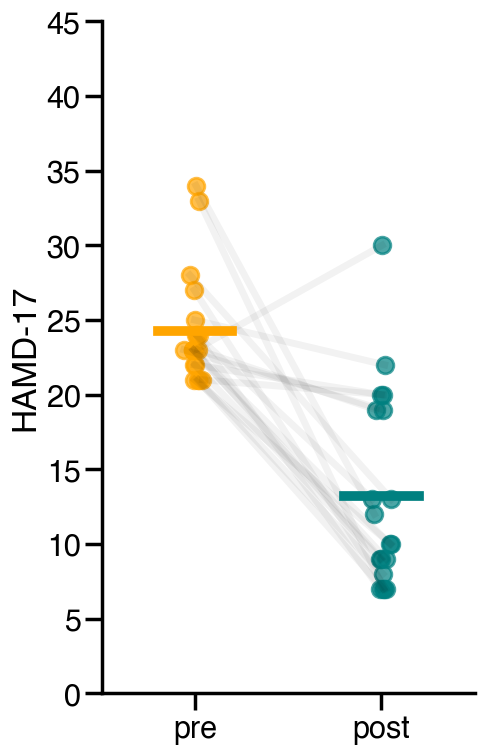

In [17]:
plot_feature_prepost(ECT_clin_eeg_diff, feature='HAMD_TotalPre', tx_type='ECT')
plt.ylabel('HAMD-17');
plt.ylim([0,45])
sns.despine()

In [18]:
ttest(x=ECT_clin_eeg_diff['HAMD_TotalPre'], y=ECT_clin_eeg_diff['HAMD_TotalPost'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.93785,18,two-sided,0.000013,"[7.14, 14.96]",2.065479,1766.477,1.0


In [19]:
print('pre = '+ str(ECT_clin_eeg_diff[ECT_clin_eeg_diff['HAMD_TotalPost'].notna()]['HAMD_TotalPre'].mean())\
      + ' std = ' + str(ECT_clin_eeg_diff[ECT_clin_eeg_diff['HAMD_TotalPost'].notna()]['HAMD_TotalPre'].std()))

print('post = '+ str(ECT_clin_eeg_diff[ECT_clin_eeg_diff['HAMD_TotalPost'].notna()]['HAMD_TotalPost'].mean())\
      + ' std = ' + str(ECT_clin_eeg_diff[ECT_clin_eeg_diff['HAMD_TotalPost'].notna()]['HAMD_TotalPost'].std()))

pre = 24.263157894736842 std = 3.7689094394231732
post = 13.210526315789474 std = 6.562341616022448


In [20]:
ttest(x=MST_clin_eeg_diff['HAMD_TotalPre'], y=MST_clin_eeg_diff['HAMD_TotalPost'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.142088,14,two-sided,0.000997,"[3.25, 10.22]",0.925102,38.814,0.914382


In [21]:
print('pre = '+ str(MST_clin_eeg_diff[MST_clin_eeg_diff['HAMD_TotalPost'].notna()]['HAMD_TotalPre'].mean())\
      + ' std = ' + str(MST_clin_eeg_diff[MST_clin_eeg_diff['HAMD_TotalPost'].notna()]['HAMD_TotalPre'].std()))

print('post = '+ str(MST_clin_eeg_diff[MST_clin_eeg_diff['HAMD_TotalPost'].notna()]['HAMD_TotalPost'].mean())\
     + ' std = ' + str(MST_clin_eeg_diff[MST_clin_eeg_diff['HAMD_TotalPost'].notna()]['HAMD_TotalPost'].std()))

pre = 28.133333333333333 std = 6.3004157081289565
post = 21.4 std = 8.139849068449786


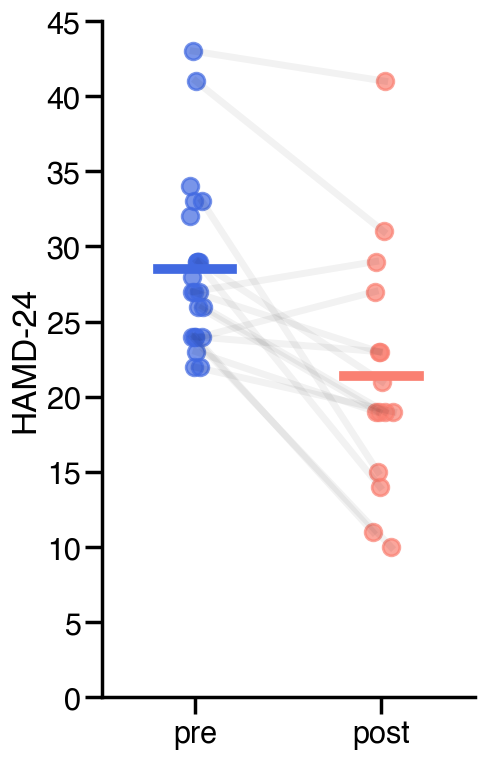

In [22]:
plot_feature_prepost(MST_clin_eeg_diff, feature='HAMD_TotalPre', tx_type='MST')
plt.ylabel('HAMD-24');
plt.ylim([0,45])
sns.despine()

In [23]:
ttest(ECT_clin_eeg_diff['HAMD_ratio'], MST_clin_eeg_diff['HAMD_ratio'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.233514,31.967316,two-sided,0.03264,"[0.02, 0.38]",0.746655,2.107,0.554369


In [24]:
ECT_clin_eeg_diff.columns

Index(['patient', 'HAMD_TotalPre', 'HAMD_TotalPost', 'MADRS_TotalPre',
       'MADRS_TotalPost', 'n_TxsReceived', 'HAMD_diff', 'HAMD_ratio',
       'MADRS_diff', 'MADRS_ratio', 'delta_cf', 'delta_bw', 'delta_amp',
       'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp', 'theta_bp', 'alpha_cf',
       'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent',
       'delta_present', 'ch_delta_perc', 'theta_present', 'ch_theta_perc',
       'new_patientID', 'treatment_type'],
      dtype='object')

In [25]:
print('ect = ' + str(ECT_clin_eeg_diff['HAMD_TotalPost'].mean()))
print('ect std = ' + str(ECT_clin_eeg_diff['HAMD_TotalPost'].std()))
print('mst = ' + str(MST_clin_eeg_diff['HAMD_TotalPost'].mean()))
print('mst std = ' + str(MST_clin_eeg_diff['HAMD_TotalPost'].std()))

ect = 13.210526315789474
ect std = 6.562341616022448
mst = 21.4
mst std = 8.139849068449786


### HAM-D ratio

In [26]:
print('ect ratio = '+ str(ECT_clin_eeg_diff['HAMD_ratio'].mean())\
      + ' std = ' + str(ECT_clin_eeg_diff['HAMD_ratio'].std()))

print('mst ratio = '+ str(MST_clin_eeg_diff['HAMD_ratio'].mean())\
     + ' std = ' + str(MST_clin_eeg_diff['HAMD_ratio'].std()))

ect ratio = 0.4401635421059301 std = 0.2977277244527926
mst ratio = 0.23956340131373005 std = 0.22586963376676814


# 4. Multiple Linear Regression

HAMD_ratio ~ treatment_type(discrete) + n_sessions(discrete) + d_exponent  + d_theta_osc_perc  
HAMD_diff ~ treatment_type(discrete) + n_sessions(discreet) + d_exponent + d_theta_osc_perc

In [27]:
sns.set_context('paper')

In [28]:
ECT_MST_clin_eeg_diff['HAMD_ratio'].mean(skipna=True)

0.3516634799917242

In [29]:
formula = 'HAMD_ratio ~ C(treatment_type) + n_TxsReceived + exponent + ch_theta_perc + exponent:n_TxsReceived'

model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     1.784
Date:                Tue, 09 May 2023   Prob (F-statistic):              0.150
Time:                        14:08:58   Log-Likelihood:              -0.055979
No. Observations:                  33   AIC:                             12.11
Df Residuals:                      27   BIC:                             21.09
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

eval_env: 1


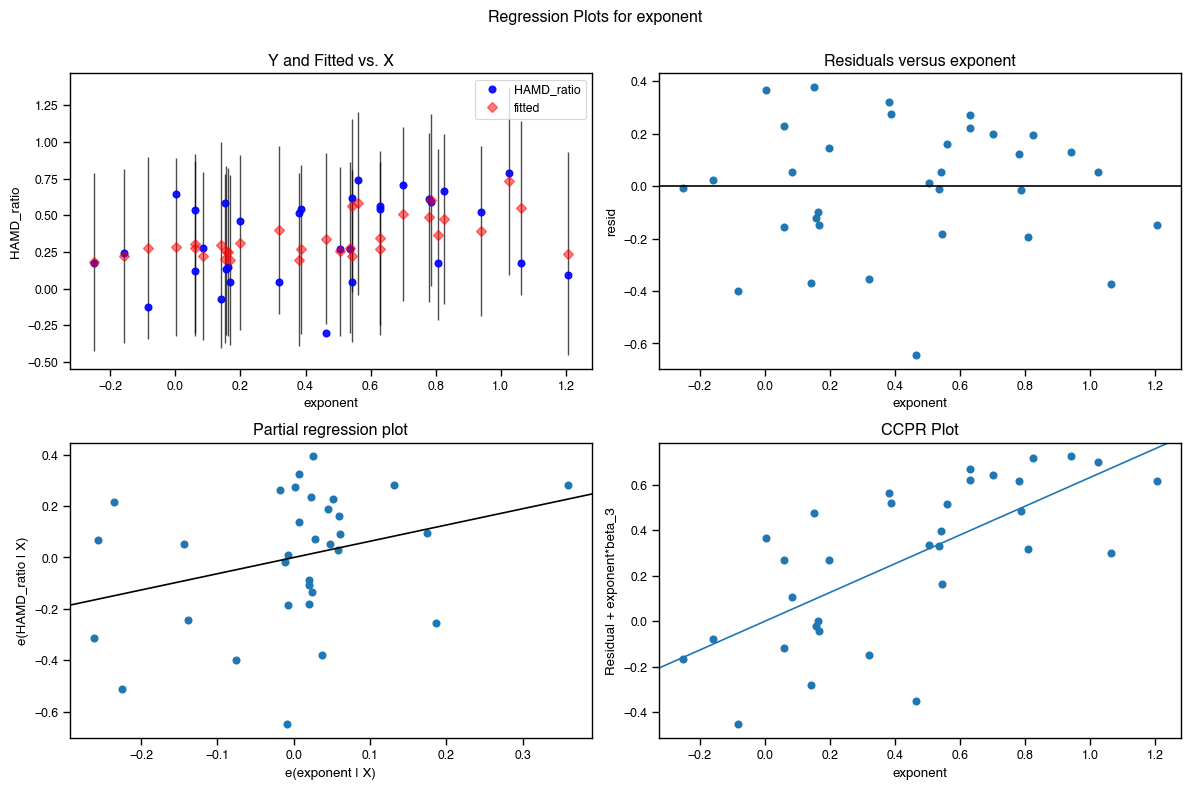

In [30]:
fig = plt.figure(figsize=(12,8))

fig = sm.graphics.plot_regress_exog(model, 'exponent', fig=fig)

# This is the one i used in the paper!!!

In [31]:
formula = 'HAMD_ratio ~ exponent:n_TxsReceived + exponent + ch_theta_perc '

model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     3.120
Date:                Tue, 09 May 2023   Prob (F-statistic):             0.0412
Time:                        14:09:20   Log-Likelihood:               -0.14984
No. Observations:                  33   AIC:                             8.300
Df Residuals:                      29   BIC:                             14.29
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [138]:
formula = 'HAMD_TotalPre-HAMD_TotalPost ~ exponent + C(treatment_type) + exponent:n_TxsReceived'

model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          HAMD_TotalPre   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     3.455
Date:                Tue, 09 May 2023   Prob (F-statistic):             0.0258
Time:                        17:07:16   Log-Likelihood:                -123.18
No. Observations:                  42   AIC:                             254.4
Df Residuals:                      38   BIC:                             261.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [97]:
features = ['HAMD_TotalPre', 'HAMD_TotalPost', 'n_TxsReceived', 'exponent',
             'ch_theta_perc']

<AxesSubplot:>

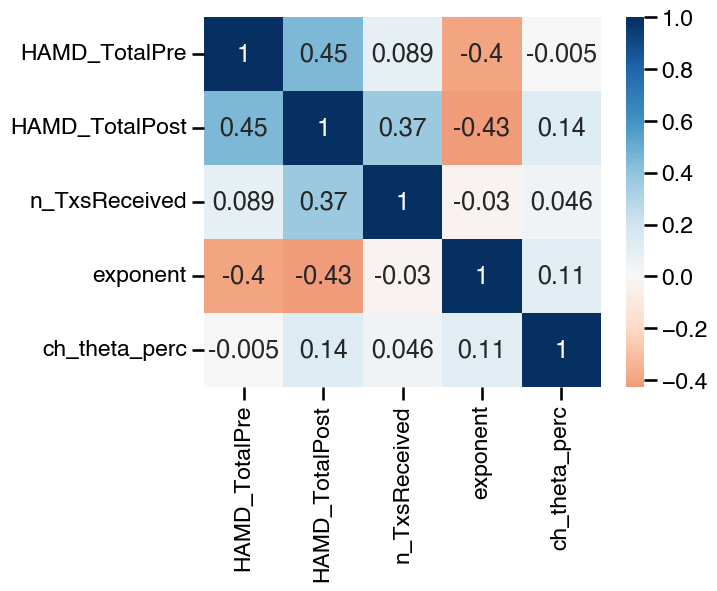

In [98]:
sns.set_context('talk')
sns.heatmap(ECT_MST_clin_eeg_diff[features].corr(), cmap='RdBu', center=0, annot=True)

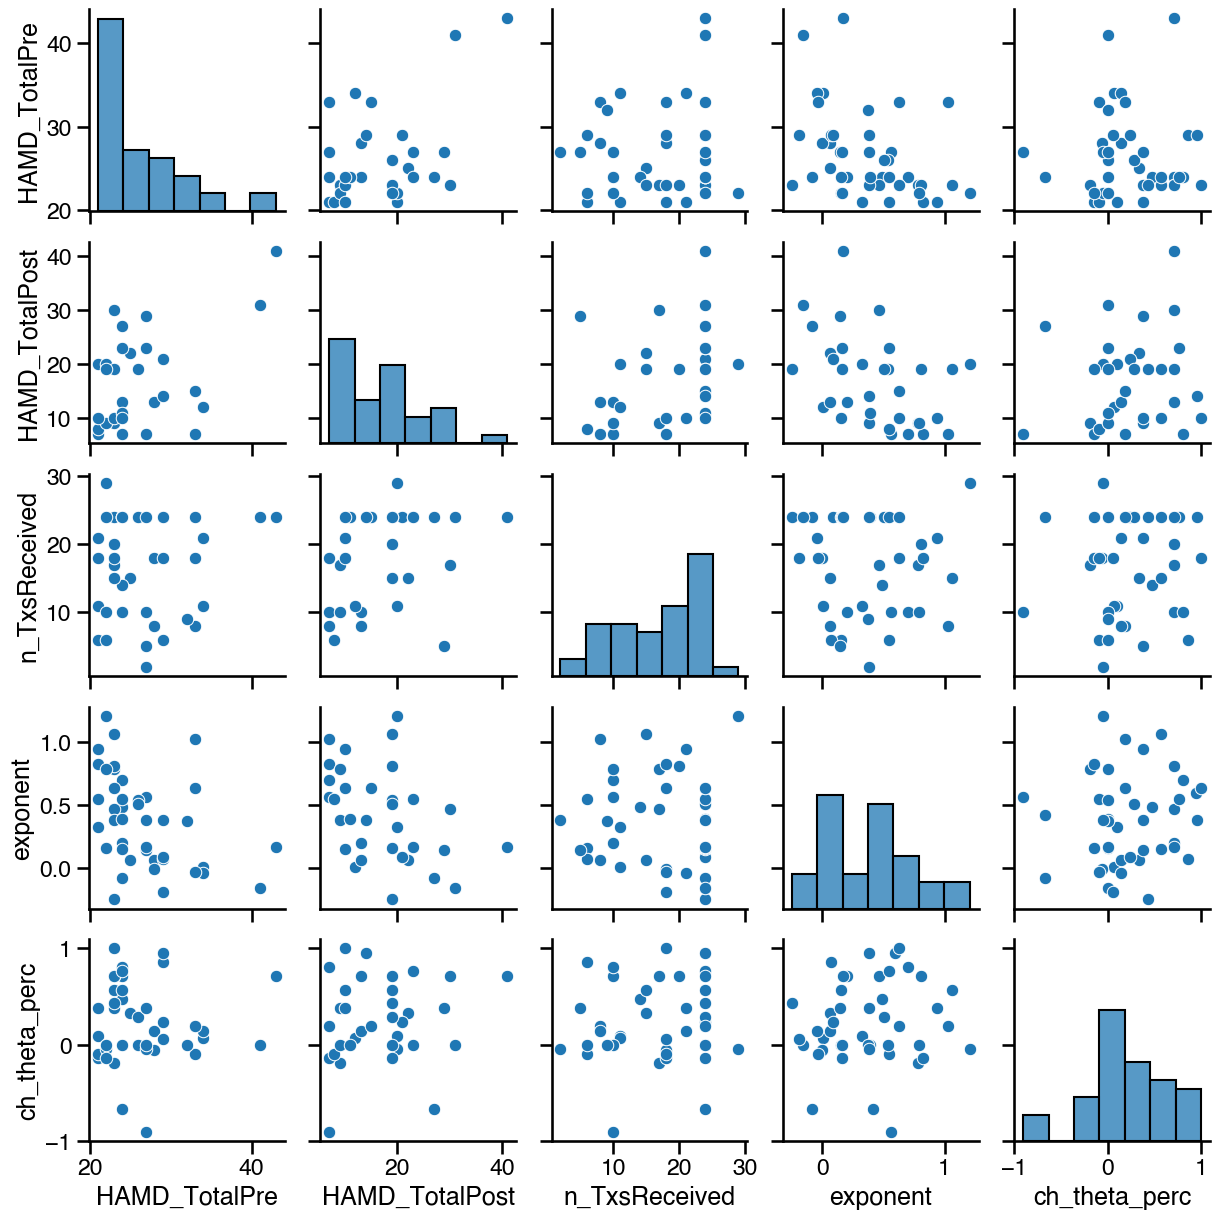

In [99]:
sns.pairplot(ECT_MST_clin_eeg_diff[features])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'baseline exponent')

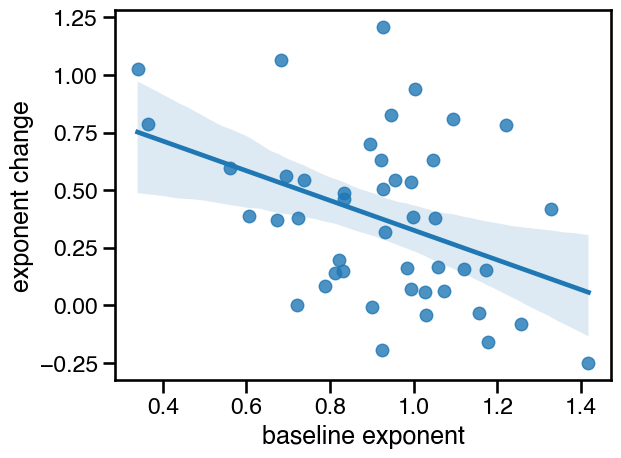

In [108]:
sns.regplot(ECT_MST_clin_eeg_pre['exponent'], ECT_MST_clin_eeg_diff['exponent'])
plt.ylabel('exponent change')
plt.xlabel('baseline exponent')

In [32]:
formula = 'HAMD_ratio ~ exponent:n_TxsReceived + exponent + ch_theta_perc + ch_delta_perc'

model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     2.268
Date:                Tue, 09 May 2023   Prob (F-statistic):             0.0870
Time:                        14:09:20   Log-Likelihood:               -0.13366
No. Observations:                  33   AIC:                             10.27
Df Residuals:                      28   BIC:                             17.75
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [33]:
ECT_MST_clin_eeg_diff[['delta_amp', 'treatment_type']]

,delta_amp,treatment_type
0,NaN,ECT
1,-0.114182,ECT
2,NaN,ECT
3,0.017966,ECT
4,NaN,ECT
5,NaN,ECT
6,NaN,ECT
7,-0.365268,ECT
8,0.947308,ECT
9,0.333180,ECT


eval_env: 1


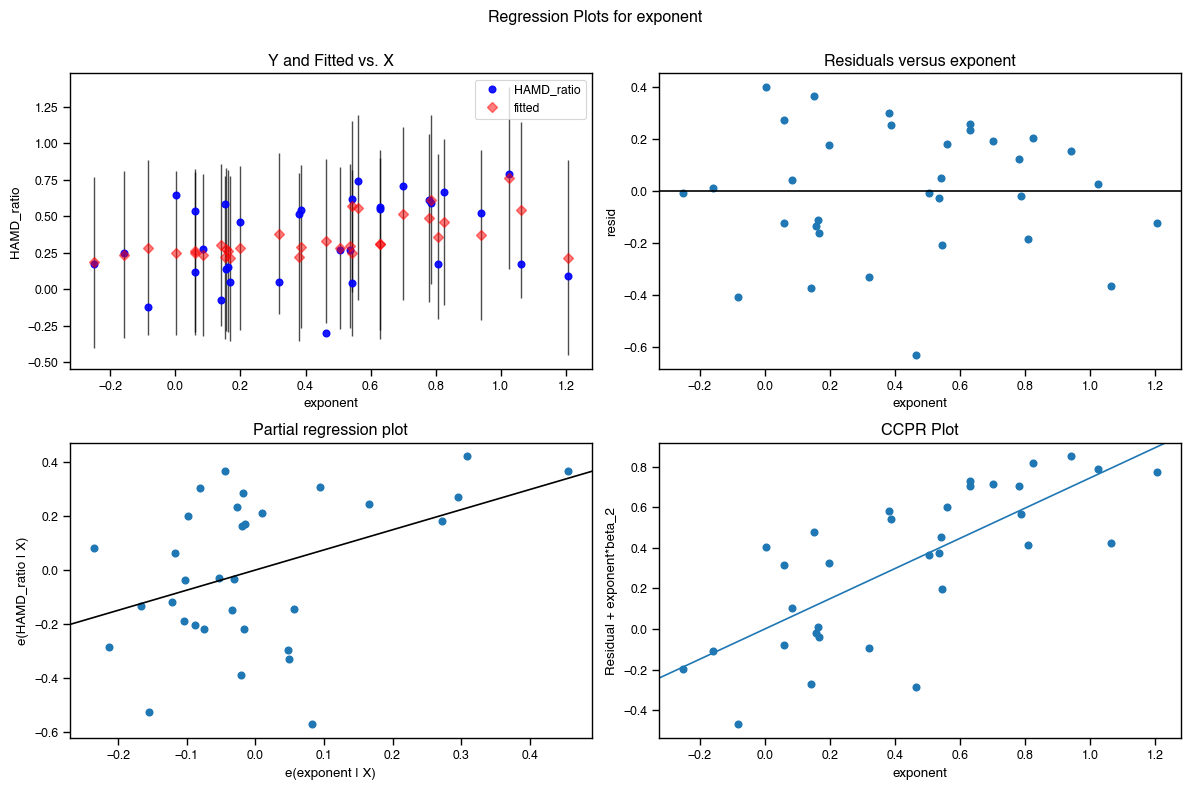

In [34]:
fig = plt.figure(figsize=(12,8))

fig = sm.graphics.plot_regress_exog(model, 'exponent', fig=fig)

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='HAMD_ratio'>

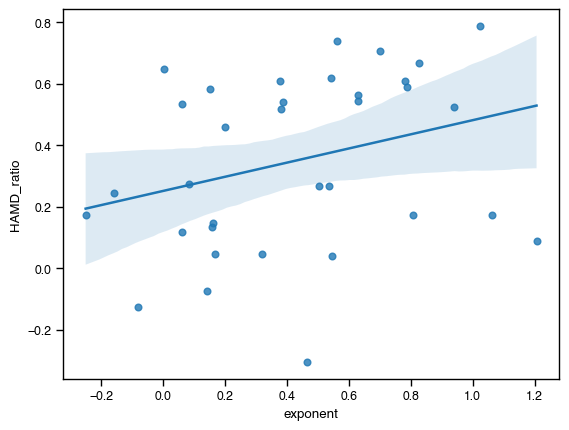

In [35]:
sns.regplot(ECT_MST_clin_eeg_diff['exponent'], ECT_MST_clin_eeg_diff['HAMD_ratio'])

In [36]:
corr(ECT_MST_clin_eeg_diff['exponent'], ECT_MST_clin_eeg_diff['HAMD_ratio'])

,n,r,CI95%,p-val,BF10,power
pearson,34,0.298923,"[-0.04, 0.58]",0.08592,0.879,0.412295


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='HAMD_diff'>

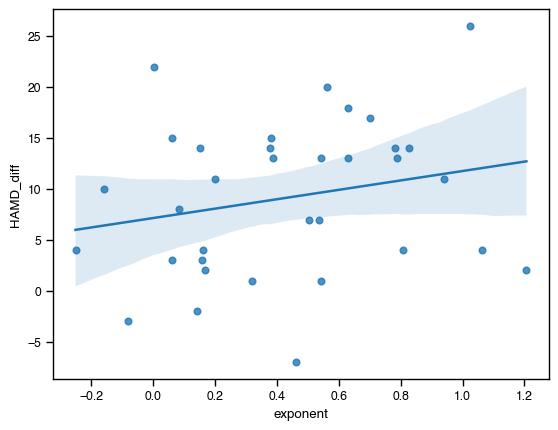

In [37]:
sns.regplot(ECT_MST_clin_eeg_diff['exponent'], ECT_MST_clin_eeg_diff['HAMD_diff'])

In [38]:
corr(ECT_MST_clin_eeg_diff['exponent'], ECT_MST_clin_eeg_diff['HAMD_diff'])

,n,r,CI95%,p-val,BF10,power
pearson,34,0.224379,"[-0.12, 0.52]",0.202046,0.466,0.250713


In [39]:
formula = 'HAMD_diff ~ exponent + ch_theta_perc + exponent:n_TxsReceived'

model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

# Pre-treatment EEG measures as predictors for treatment response

                            OLS Regression Results                            
Dep. Variable:              HAMD_diff   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     2.421
Date:                Tue, 09 May 2023   Prob (F-statistic):             0.0862
Time:                        14:09:22   Log-Likelihood:                -109.77
No. Observations:                  33   AIC:                             227.5
Df Residuals:                      29   BIC:                             233.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

In [40]:
formula = 'HAMD_ratio ~ exponent + exponent:n_TxsReceived'


model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     4.505
Date:                Tue, 09 May 2023   Prob (F-statistic):             0.0195
Time:                        14:09:22   Log-Likelihood:               -0.43149
No. Observations:                  33   AIC:                             6.863
Df Residuals:                      30   BIC:                             11.35
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [41]:
formula = 'HAMD_ratio ~ exponent + ch_theta_perc + exponent:n_TxsReceived'


model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     3.120
Date:                Tue, 09 May 2023   Prob (F-statistic):             0.0412
Time:                        14:09:22   Log-Likelihood:               -0.14984
No. Observations:                  33   AIC:                             8.300
Df Residuals:                      29   BIC:                             14.29
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

eval_env: 1


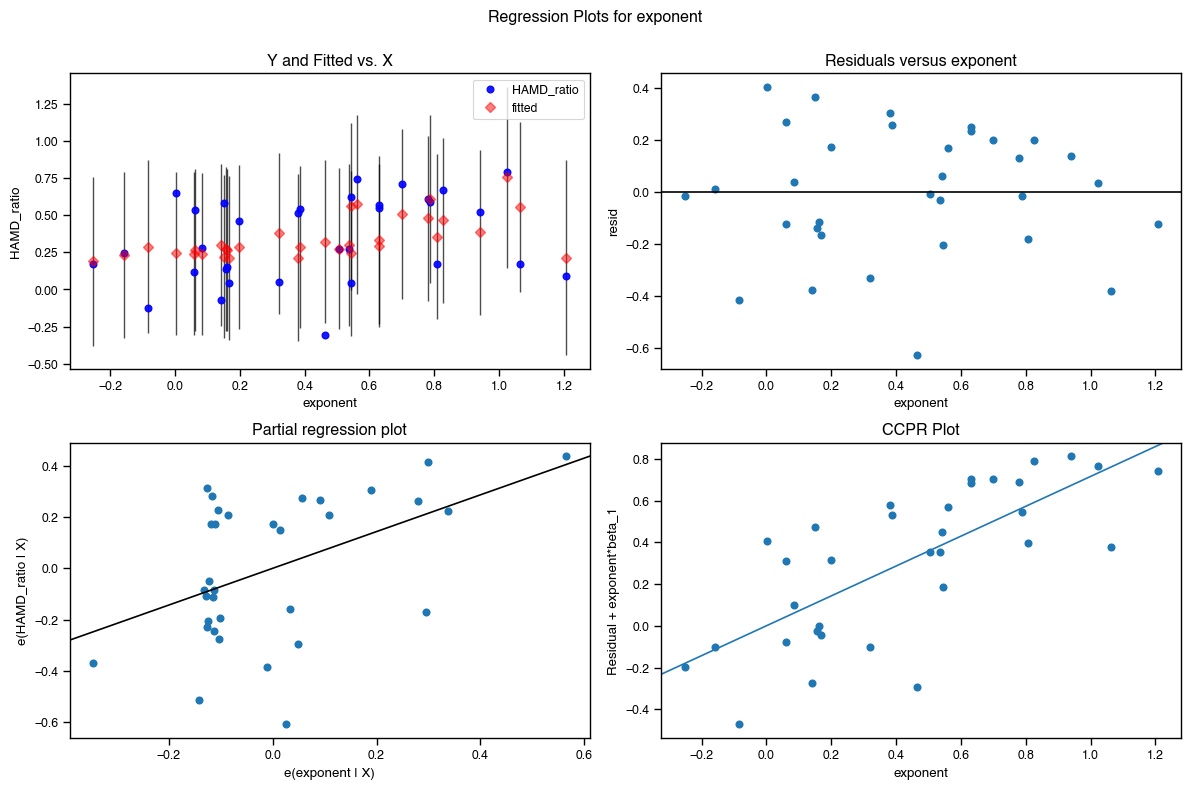

In [42]:
fig = plt.figure(figsize=(12,8))
sns.set_context('paper')

fig = sm.graphics.plot_regress_exog(model, 'exponent', fig=fig)

In [43]:
# determine % of MST sample that got 24 (max) treatments

ECT_MST_clin_eeg_diff[ECT_MST_clin_eeg_diff['n_TxsReceived']==24]

,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,MADRS_ratio,...,alpha_amp,alpha_bp,offset,exponent,delta_present,ch_delta_perc,theta_present,ch_theta_perc,new_patientID,treatment_type
0,9,23.0,19.0,NaN,NaN,24.0,4.0,0.173913,NaN,NaN,...,0.070322,-0.282926,-0.445872,-0.251241,-1.0,-0.047619,9.0,0.428571,MST_9,MST
2,18,24.0,27.0,NaN,NaN,24.0,-3.0,-0.125000,NaN,NaN,...,-0.120242,-0.132427,-0.130354,-0.082965,-0.0,-0.000000,-14.0,-0.666667,MST_18,MST
5,33,26.0,19.0,NaN,NaN,24.0,7.0,0.269231,NaN,NaN,...,-0.235333,-0.024690,0.580304,0.535556,7.0,0.333333,-0.0,-0.000000,MST_33,MST
7,40,24.0,11.0,NaN,NaN,24.0,13.0,0.541667,NaN,NaN,...,0.097648,0.015390,0.330098,0.386498,-0.0,-0.000000,-0.0,-0.000000,MST_40,MST
8,46,29.0,21.0,NaN,NaN,24.0,8.0,0.275862,NaN,NaN,...,-0.056855,-0.144221,-0.021992,0.083870,-0.0,-0.000000,5.0,0.238095,MST_46,MST
9,47,41.0,31.0,NaN,NaN,24.0,10.0,0.243902,NaN,NaN,...,0.312322,-0.081481,-0.260587,-0.158450,-6.0,-0.285714,-0.0,-0.000000,MST_47,MST
11,66,26.0,19.0,NaN,NaN,24.0,7.0,0.269231,NaN,NaN,...,-0.447931,0.216994,0.936839,0.504517,2.0,0.095238,6.0,0.285714,MST_66,MST
12,69,24.0,23.0,NaN,NaN,24.0,1.0,0.041667,NaN,NaN,...,-0.815423,-0.401006,0.569802,0.543891,2.0,0.095238,16.0,0.761905,MST_69,MST
13,95,33.0,15.0,NaN,NaN,24.0,18.0,0.545455,NaN,NaN,...,-0.114798,0.283870,0.841624,0.630281,-3.0,-0.142857,4.0,0.190476,MST_95,MST
18,130,24.0,10.0,NaN,NaN,24.0,14.0,0.583333,NaN,NaN,...,0.328857,0.318710,0.164744,0.151282,-0.0,-0.000000,12.0,0.571429,MST_130,MST


In [44]:
14/23

0.6086956521739131

In [45]:
# re-run regresion excluding MST participants that maxed out treatment (!=24)
formula = 'HAMD_ratio ~ exponent + ch_theta_perc + exponent:n_TxsReceived + C(treatment_type) + n_TxsReceived:treatment_type'

no24_df = pd.DataFrame(ECT_MST_clin_eeg_diff[ECT_MST_clin_eeg_diff['n_TxsReceived']!=24]).reset_index()


model = ols(formula, no24_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     2.174
Date:                Tue, 09 May 2023   Prob (F-statistic):              0.120
Time:                        14:09:23   Log-Likelihood:                 1.1641
No. Observations:                  19   AIC:                             9.672
Df Residuals:                      13   BIC:                             15.34
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [46]:
# investigate the interaction between exponent and n_TxsRecieved

sherlock_df = pd.DataFrame(ECT_MST_clin_eeg_diff[['HAMD_ratio', 'n_TxsReceived', 'exponent', 'treatment_type']])

In [47]:
sherlock_df_filt = sherlock_df[~sherlock_df['HAMD_ratio'].isna()]

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='n_TxsReceived', ylabel='exponent'>

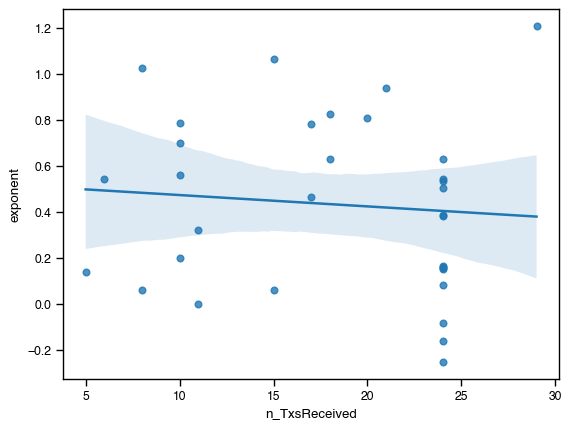

In [48]:
sns.regplot(sherlock_df_filt['n_TxsReceived'], sherlock_df_filt['exponent'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='n_TxsReceived', ylabel='exponent'>

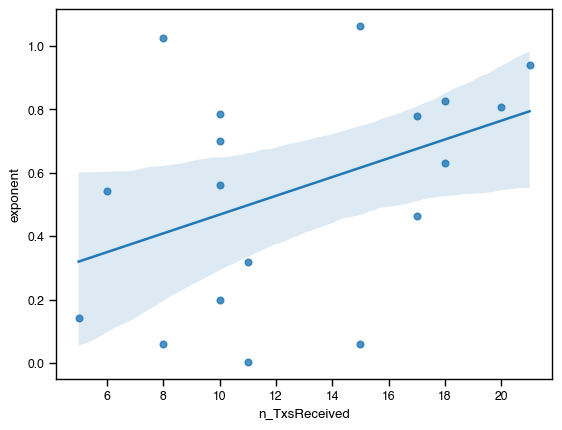

In [49]:
sns.regplot(sherlock_df_filt[sherlock_df_filt['n_TxsReceived']<24]['n_TxsReceived'],
            sherlock_df_filt[sherlock_df_filt['n_TxsReceived']<24]['exponent'])

In [50]:
corr(sherlock_df_filt[sherlock_df_filt['n_TxsReceived']<24]['n_TxsReceived'],
            sherlock_df_filt[sherlock_df_filt['n_TxsReceived']<24]['exponent'])

,n,r,CI95%,p-val,BF10,power
pearson,18,0.418809,"[-0.06, 0.74]",0.083656,1.171,0.424382


In [51]:
formula = 'HAMD_ratio ~ n_TxsReceived + C(treatment_type) + exponent + ch_theta_perc + exponent:n_TxsReceived'


model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     1.784
Date:                Tue, 09 May 2023   Prob (F-statistic):              0.150
Time:                        14:09:39   Log-Likelihood:              -0.055979
No. Observations:                  33   AIC:                             12.11
Df Residuals:                      27   BIC:                             21.09
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

eval_env: 1


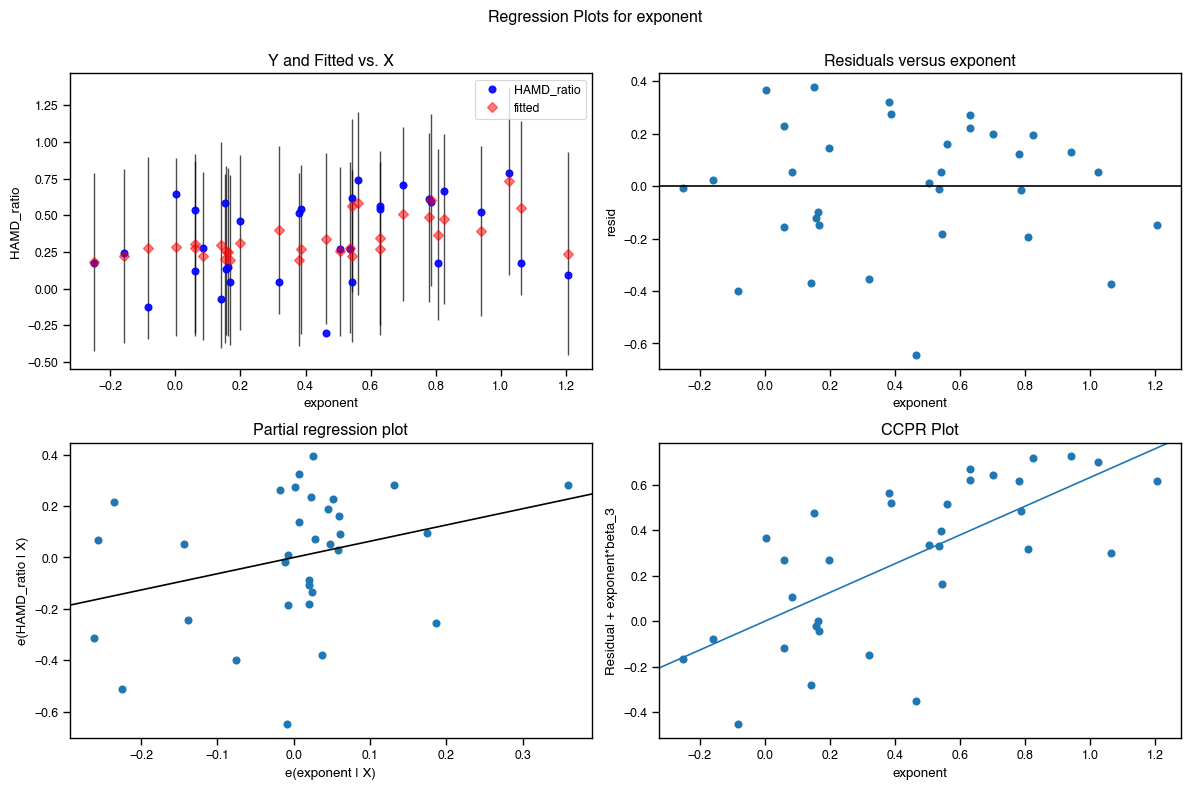

In [52]:
fig = plt.figure(figsize=(12,8))

fig = sm.graphics.plot_regress_exog(model, 'exponent', fig=fig)

In [53]:
formula = 'HAMD_ratio ~ C(treatment_type) + exponent + ch_theta_perc + exponent:n_TxsReceived'


model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     2.311
Date:                Tue, 09 May 2023   Prob (F-statistic):             0.0825
Time:                        14:09:39   Log-Likelihood:              -0.058288
No. Observations:                  33   AIC:                             10.12
Df Residuals:                      28   BIC:                             17.60
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [54]:
formula = 'HAMD_ratio ~ exponent + n_TxsReceived + C(treatment_type) + exponent:n_TxsReceived + n_TxsReceived:C(treatment_type)'

model = ols(formula, ECT_MST_clin_eeg_diff).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     3.389
Date:                Tue, 09 May 2023   Prob (F-statistic):             0.0167
Time:                        14:09:39   Log-Likelihood:                 3.2714
No. Observations:                  33   AIC:                             5.457
Df Residuals:                      27   BIC:                             14.44
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

# Pre-treatment EEG measures regression

In [100]:
ECT_path_pre = '../saved_files_appeal/ect_files/ect_clin_eeg_pre.csv'
MST_path_pre = '../saved_files_appeal/mst_files/mst_clin_eeg_pre.csv'

In [101]:
ECT_clin_eeg_pre = pd.read_csv(ECT_path_pre)
MST_clin_eeg_pre = pd.read_csv(MST_path_pre)

In [102]:
# Add column for treatment type
MST_clin_eeg_pre['treatment_type'] = np.tile('MST', len(MST_clin_eeg_pre['patient']))
ECT_clin_eeg_pre['treatment_type'] = np.tile('ECT', len(ECT_clin_eeg_pre['patient']))

In [103]:
MST_clin_eeg_pre.columns

Index(['Unnamed: 0', 'patient', 'HAMD_TotalPre', 'HAMD_TotalPost',
       'n_TxsReceived', 'HAMD_diff', 'HAMD_ratio', 'pre_post', 'delta_cf',
       'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw',
       'theta_amp', 'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp',
       'alpha_bp', 'offset', 'exponent', 'delta_present', 'ch_delta_perc',
       'theta_present', 'ch_theta_perc', 'treatment_type'],
      dtype='object')

In [104]:
ECT_MST_clin_eeg_pre = pd.concat([ECT_clin_eeg_pre, MST_clin_eeg_pre], ignore_index=True)

In [60]:
formula = 'HAMD_ratio ~ exponent + C(treatment_type) '

model = ols(formula, ECT_MST_clin_eeg_pre).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     4.478
Date:                Tue, 09 May 2023   Prob (F-statistic):             0.0196
Time:                        14:09:41   Log-Likelihood:               -0.53013
No. Observations:                  34   AIC:                             7.060
Df Residuals:                      31   BIC:                             11.64
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [61]:
ECT_MST_clin_eeg_pre

,Unnamed: 0,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,...,alpha_bw,alpha_amp,alpha_bp,offset,exponent,delta_present,ch_delta_perc,theta_present,ch_theta_perc,treatment_type
0,0,3,33.0,7.0,42.0,8.0,8.0,26.0,0.787879,34.0,...,1.449038,0.694311,-11.900750,-12.032917,0.339566,0,0.000000,17,0.809524,ECT
1,1,4,24.0,13.0,NaN,NaN,10.0,11.0,0.458333,NaN,...,1.511450,1.458963,-11.327265,-11.515600,0.820470,1,0.047619,0,0.000000,ECT
2,2,10,21.0,20.0,31.0,25.0,11.0,1.0,0.047619,6.0,...,1.306758,1.215247,-11.866269,-11.686848,0.931087,0,0.000000,19,0.904762,ECT
3,3,13,25.0,22.0,32.0,NaN,15.0,3.0,0.120000,NaN,...,1.033290,1.402025,-11.686568,-11.615048,1.026275,13,0.619048,0,0.000000,ECT
4,4,16,24.0,NaN,35.0,NaN,14.0,NaN,NaN,NaN,...,2.252768,0.905743,-11.690054,-11.596002,0.833458,0,0.000000,8,0.380952,ECT
5,5,18,23.0,30.0,32.0,35.0,17.0,-7.0,-0.304348,-3.0,...,1.372158,0.351864,-12.309103,-11.716429,0.834459,0,0.000000,0,0.000000,ECT
6,6,19,34.0,12.0,41.0,9.0,11.0,22.0,0.647059,32.0,...,1.204090,1.803531,-12.124270,-12.398633,0.720200,3,0.200000,0,0.000000,ECT
7,7,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.239371,0.469951,-12.643741,-12.282827,0.560167,1,0.050000,0,0.000000,ECT
8,8,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.406508,0.253045,-12.890505,-11.767281,1.328952,19,0.904762,16,0.761905,ECT
9,9,31,23.0,9.0,31.0,10.0,17.0,14.0,0.608696,21.0,...,1.780751,1.965714,-10.670318,-10.937287,1.219604,17,0.809524,21,1.000000,ECT


In [62]:
corr(ECT_MST_clin_eeg_pre['exponent'], ECT_MST_clin_eeg_pre['HAMD_ratio'], method='spearman')

,n,r,CI95%,p-val,power
spearman,34,-0.37435,"[-0.63, -0.04]",0.02917,0.601991


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='HAMD_ratio'>

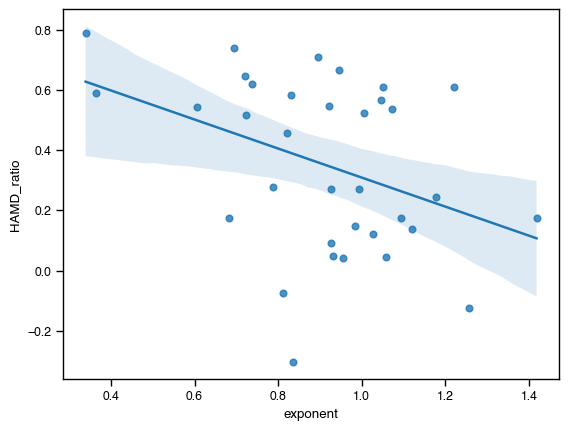

In [63]:
sns.regplot(ECT_MST_clin_eeg_pre['exponent'], ECT_MST_clin_eeg_pre['HAMD_ratio'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='HAMD_ratio'>

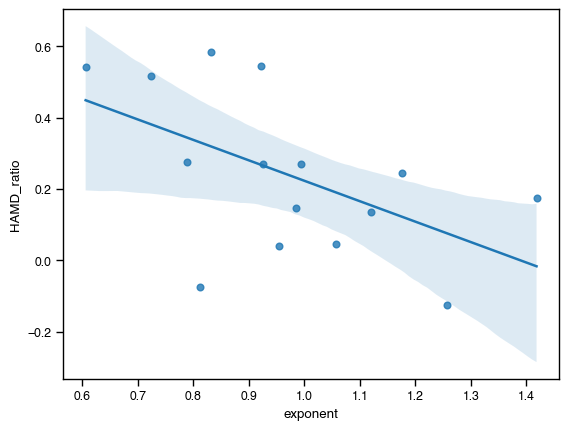

In [64]:
sns.regplot(MST_clin_eeg_pre['exponent'], 
            MST_clin_eeg_pre['HAMD_ratio'])

In [65]:
ECT_clin_eeg_pre

,Unnamed: 0,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,...,alpha_bw,alpha_amp,alpha_bp,offset,exponent,delta_present,ch_delta_perc,theta_present,ch_theta_perc,treatment_type
0,0,3,33.0,7.0,42.0,8.0,8.0,26.0,0.787879,34.0,...,1.449038,0.694311,-11.900750,-12.032917,0.339566,0,0.000000,17,0.809524,ECT
1,1,4,24.0,13.0,NaN,NaN,10.0,11.0,0.458333,NaN,...,1.511450,1.458963,-11.327265,-11.515600,0.820470,1,0.047619,0,0.000000,ECT
2,2,10,21.0,20.0,31.0,25.0,11.0,1.0,0.047619,6.0,...,1.306758,1.215247,-11.866269,-11.686848,0.931087,0,0.000000,19,0.904762,ECT
3,3,13,25.0,22.0,32.0,NaN,15.0,3.0,0.120000,NaN,...,1.033290,1.402025,-11.686568,-11.615048,1.026275,13,0.619048,0,0.000000,ECT
4,4,16,24.0,NaN,35.0,NaN,14.0,NaN,NaN,NaN,...,2.252768,0.905743,-11.690054,-11.596002,0.833458,0,0.000000,8,0.380952,ECT
5,5,18,23.0,30.0,32.0,35.0,17.0,-7.0,-0.304348,-3.0,...,1.372158,0.351864,-12.309103,-11.716429,0.834459,0,0.000000,0,0.000000,ECT
6,6,19,34.0,12.0,41.0,9.0,11.0,22.0,0.647059,32.0,...,1.204090,1.803531,-12.124270,-12.398633,0.720200,3,0.200000,0,0.000000,ECT
7,7,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.239371,0.469951,-12.643741,-12.282827,0.560167,1,0.050000,0,0.000000,ECT
8,8,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.406508,0.253045,-12.890505,-11.767281,1.328952,19,0.904762,16,0.761905,ECT
9,9,31,23.0,9.0,31.0,10.0,17.0,14.0,0.608696,21.0,...,1.780751,1.965714,-10.670318,-10.937287,1.219604,17,0.809524,21,1.000000,ECT


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '$\\Delta$ exponent')

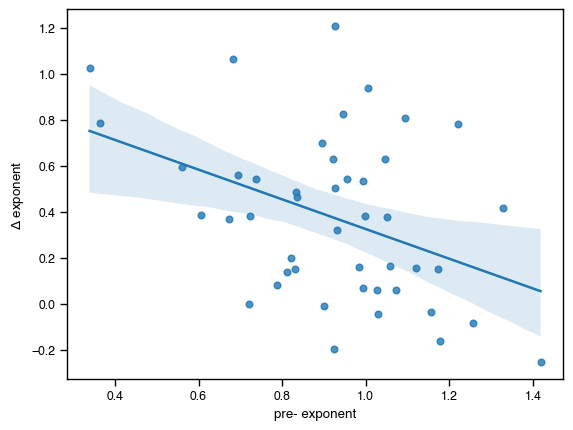

In [66]:
sns.regplot(ECT_MST_clin_eeg_pre['exponent'], ECT_MST_clin_eeg_diff['exponent'])
plt.xlabel('pre- exponent')
plt.ylabel('$\Delta$ exponent')

In [67]:
corr(ECT_MST_clin_eeg_pre['exponent'], ECT_MST_clin_eeg_diff['exponent'], method='spearman')

,n,r,CI95%,p-val,power
spearman,45,-0.332938,"[-0.57, -0.04]",0.025434,0.619729


# Baseline + change regression

In [125]:
ect_mst_pre_diff_clin = pd.DataFrame()
ect_mst_pre_diff_clin['patient'] = ECT_MST_clin_eeg_diff['patient']
ect_mst_pre_diff_clin['treatment_type'] = ECT_MST_clin_eeg_diff['treatment_type']
ect_mst_pre_diff_clin['pre_exponent'] = ECT_MST_clin_eeg_pre['exponent']
ect_mst_pre_diff_clin['d_exponent'] = ECT_MST_clin_eeg_diff['exponent']
ect_mst_pre_diff_clin['HAMD_ratio'] = ECT_MST_clin_eeg_diff['HAMD_ratio']
ect_mst_pre_diff_clin['HAMD_TotalPre'] = ECT_MST_clin_eeg_diff['HAMD_TotalPre']
ect_mst_pre_diff_clin['HAMD_TotalPost'] = ECT_MST_clin_eeg_diff['HAMD_TotalPost']
ect_mst_pre_diff_clin['n_TxsReceived'] = ECT_MST_clin_eeg_diff['n_TxsReceived']


In [126]:
ect_mst_pre_diff_clin

,patient,treatment_type,pre_exponent,d_exponent,HAMD_ratio,HAMD_TotalPre,HAMD_TotalPost,n_TxsReceived
0,3,ECT,0.339566,1.024118,0.787879,33.0,7.0,8.0
1,4,ECT,0.820470,0.198727,0.458333,24.0,13.0,10.0
2,10,ECT,0.931087,0.319810,0.047619,21.0,20.0,11.0
3,13,ECT,1.026275,0.059526,0.120000,25.0,22.0,15.0
4,16,ECT,0.833458,0.485470,NaN,24.0,NaN,14.0
5,18,ECT,0.834459,0.463106,-0.304348,23.0,30.0,17.0
6,19,ECT,0.720200,0.002427,0.647059,34.0,12.0,11.0
7,25,ECT,0.560167,0.594539,NaN,NaN,NaN,NaN
8,29,ECT,1.328952,0.417017,NaN,NaN,NaN,NaN
9,31,ECT,1.219604,0.780498,0.608696,23.0,9.0,17.0


In [127]:
ect_pre_diff_clin = ect_mst_pre_diff_clin[ect_mst_pre_diff_clin['treatment_type']=='ECT']

In [130]:
features = ['HAMD_TotalPre', 'HAMD_TotalPost', 'n_TxsReceived', 'pre_exponent', 'd_exponent']

<AxesSubplot:>

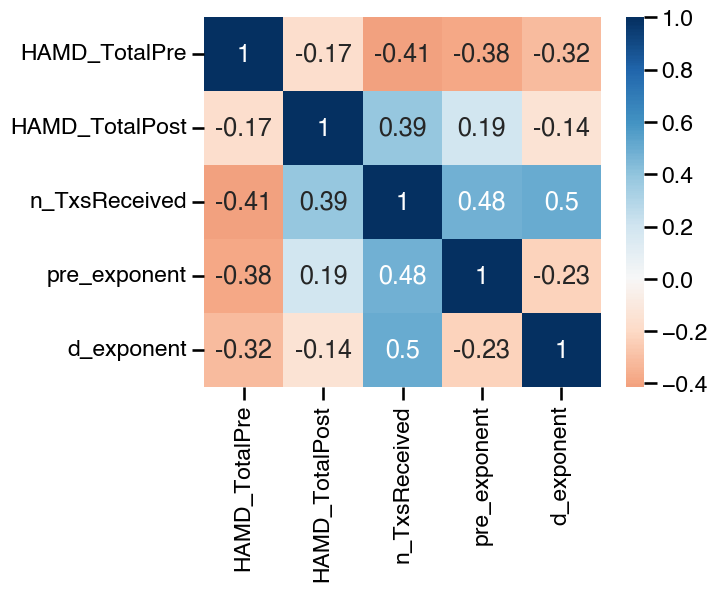

In [132]:
sns.heatmap(ect_pre_diff_clin[features].corr(), cmap='RdBu', center=0, annot=True)

In [124]:
formula = 'HAMD_TotalPost ~ HAMD_TotalPre + pre_exponent:d_exponent + d_exponent'

model = ols(formula, ect_pre_diff_clin).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         HAMD_TotalPost   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                 -0.112
Method:                 Least Squares   F-statistic:                    0.3965
Date:                Tue, 09 May 2023   Prob (F-statistic):              0.757
Time:                        16:15:43   Log-Likelihood:                -61.467
No. Observations:                  19   AIC:                             130.9
Df Residuals:                      15   BIC:                             134.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# Syd's thoughts on the replication problem:

How do we reconcile the contradictory clinical findings in the longitudinal ECT paper and the ECT/MST study?

**The problem**

The longitudinal ECT study, hereby referred to as ECT_long, found that the increase in aperiodic exponent was *inversely* related to the decrease in clinical symptom severity as measured by the QIDS-SR. It also found that *larger* values of baseline aperiodic exponent were related to *greater* symptom improvement, indicating that patients who start treatment with more aperiodic activity might be more responsive to treatment. However, in the ECT/MST study, we found the opposite relationship in both of these effects. Specifically, the increase in aperiodic exponent was *directly* related to the magnitude of the relative improvement in clinical symptom severity as measured by HAMD (more aperiodic change, more HAMD improvement). And, the baseline aperiodic exponent was predictive of treatment response where *lower* aperiodic exponent predicted *greater* clinical improvement. 

In summary:

ECT_long:  
- GREATER $\Delta$ exponent --> LESSER $\Delta$ QIDS-SR  
- GREATER baseline exponent --> GREATER $\Delta$ QIDS-SR  
    
ECT/MST:  
- GREATER $\Delta$ exponent --> GREATER $\Delta$ HAMD  
- LESSER baseline exponent --> GREATER $\Delta$ QIDS-SR  
    
    
**Differences in between the two studies:**  
- QIDS-SR vs. HAMD  
- LME_fit(QIDS-SR) vs. HAMD_ratio  
- LME_fit($\Delta$ exponent) vs. $\Delta$ exponent
- n = 9 vs. n = 33
- longitudinal vs. interventional
- ECT vs. ECT + MST
    

# What happens when we look at RELATIVE CHANGES IN EXPONENT?

relative exponent vs. relative HAMD (HAMD_ratio)

In [71]:
exponent_ratio = ECT_MST_clin_eeg_diff['exponent']/ECT_MST_clin_eeg_pre['exponent']

In [72]:
ECT_MST_clin_eeg_diff['exponent_ratio'] = exponent_ratio.values

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent_ratio', ylabel='HAMD_ratio'>

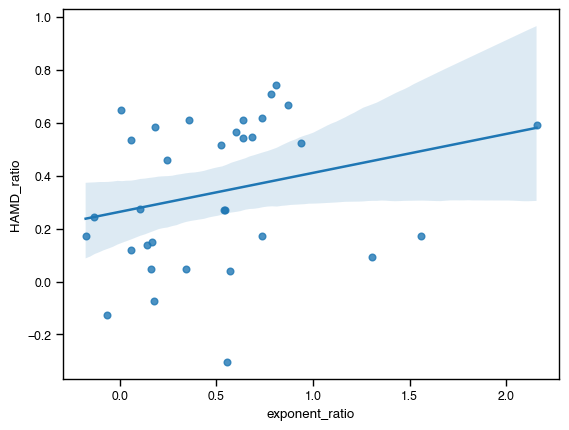

In [73]:
sns.regplot(ECT_MST_clin_eeg_diff[ECT_MST_clin_eeg_diff['exponent_ratio']<3.0]['exponent_ratio'],
            ECT_MST_clin_eeg_diff[ECT_MST_clin_eeg_diff['exponent_ratio']<3.0]['HAMD_ratio'])

# Plot Partial Regression (DIFFERENCE)

In [74]:
formula = 'HAMD_ratio ~ exponent:n_TxsReceived + exponent + ch_theta_perc'
model = ols(formula, ECT_MST_clin_eeg_diff)
fit = model.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     3.120
Date:                Tue, 09 May 2023   Prob (F-statistic):             0.0412
Time:                        14:09:45   Log-Likelihood:               -0.14984
No. Observations:                  33   AIC:                             8.300
Df Residuals:                      29   BIC:                             14.29
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [75]:
ECT_MST_clin_eeg_diff_nonan = pd.DataFrame(ECT_MST_clin_eeg_diff[ECT_MST_clin_eeg_diff['HAMD_ratio'].notna()])
ECT_MST_clin_eeg_diff_nonan = pd.DataFrame(ECT_MST_clin_eeg_diff_nonan[ECT_MST_clin_eeg_diff_nonan['n_TxsReceived'].notna()])

eval_env: 1


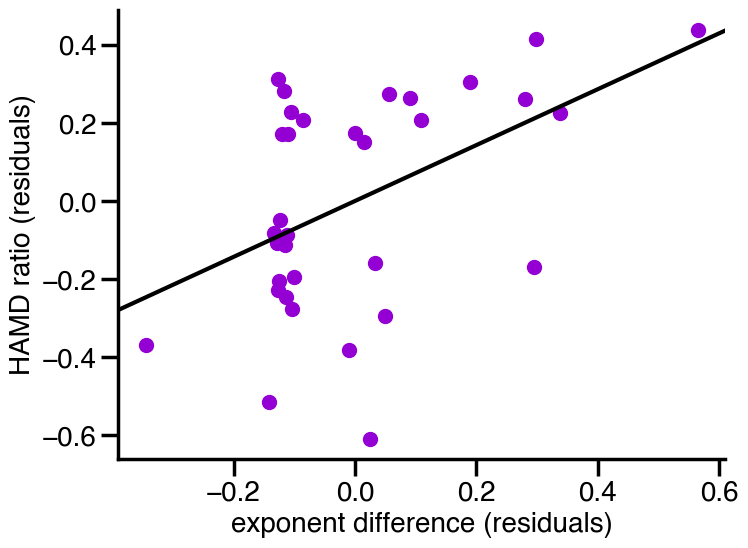

In [76]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(8,6))
sm.graphics.plot_partregress(endog="HAMD_ratio", exog_i="exponent", exog_others=["ch_theta_perc", "exponent:n_TxsReceived"], data=ECT_MST_clin_eeg_diff_nonan, obs_labels=False, color='darkviolet', ax=ax, markersize=10);
plt.xlabel('exponent difference (residuals)', size=20)
plt.ylabel('HAMD ratio (residuals)', size=20)
plt.title('', size=25)
ax.tick_params(axis='both', labelsize=20)
sns.despine()
plt.tight_layout()
plt.show()

# Plot Partial Regression (PRE)

In [77]:
formula = 'HAMD_ratio ~ exponent + ch_theta_perc '

model = ols(formula, ECT_MST_clin_eeg_pre).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     2.843
Date:                Tue, 09 May 2023   Prob (F-statistic):             0.0735
Time:                        14:09:47   Log-Likelihood:                -1.9821
No. Observations:                  34   AIC:                             9.964
Df Residuals:                      31   BIC:                             14.54
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7869      0.193      4.073

In [78]:
ECT_MST_clin_eeg_pre_nonan = pd.DataFrame(ECT_MST_clin_eeg_pre[ECT_MST_clin_eeg_pre['HAMD_ratio'].notna()])

eval_env: 1


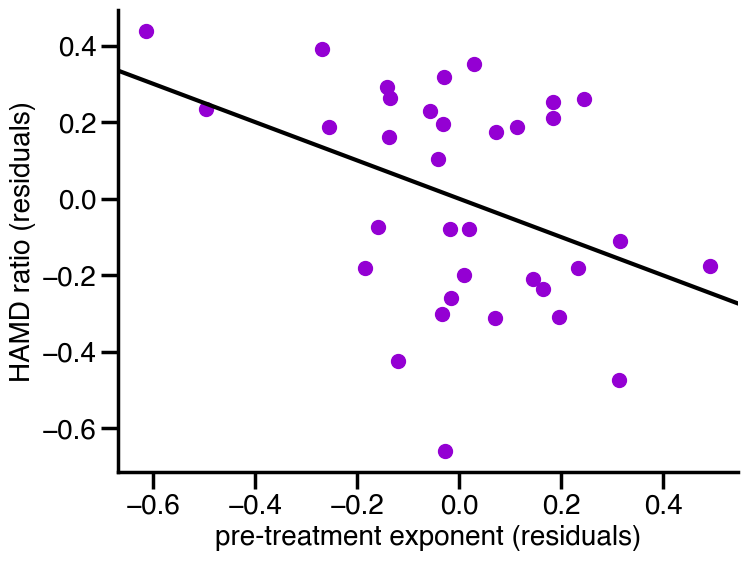

In [79]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(8,6))
sm.graphics.plot_partregress(endog="HAMD_ratio", exog_i="exponent", exog_others=["ch_theta_perc"], data=ECT_MST_clin_eeg_pre_nonan, obs_labels=False, color='darkviolet', ax=ax, markersize=10);
plt.xlabel('pre-treatment exponent (residuals)', size=20)
plt.ylabel('HAMD ratio (residuals)', size=20)
plt.title('', size=25)
ax.tick_params(axis='both', labelsize=20)
sns.despine()
plt.show()

##  Comparison of exponent changes - ECT vs. MST

In [80]:
ttest(ECT_clin_eeg_diff['exponent'], MST_clin_eeg_diff['exponent'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.609129,38.998458,two-sided,0.000043,"[0.23, 0.59]",1.383189,529.731,0.994951


In [81]:
print('ect exponent = ' + str(round(ECT_clin_eeg_diff['exponent'].mean(), 2)) \
      + ' std = ' + str(round(ECT_clin_eeg_diff['exponent'].std(), 2)))
print('mst exponent = ' + str(round(MST_clin_eeg_diff['exponent'].mean(), 2)) \
      + ' std = ' + str(round(MST_clin_eeg_diff['exponent'].std(), 2)))

ect exponent = 0.58 std = 0.33
mst exponent = 0.18 std = 0.25
